In [20]:
%pip install docaligner-docsaid

  Obtaining dependency information for docaligner-docsaid from https://files.pythonhosted.org/packages/71/d7/ed6ec6e903fa99626f3a53fa95ae02129948995e89a9ac3881df12de55d6/docaligner_docsaid-1.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for capybara_docsaid>=0.5.1 from https://files.pythonhosted.org/packages/ec/c9/ea383a1a25a91682d6eaede467d51fac2a9b3dab67a494bc2839c91afc33/capybara_docsaid-0.8.3-py3-none-any.whl.metadata
  Obtaining dependency information for dacite from https://files.pythonhosted.org/packages/94/35/386550fd60316d1e37eccdda609b074113298f23cef5bddb2049823fe666/dacite-1.9.2-py3-none-any.whl.metadata
  Obtaining dependency information for onnx from https://files.pythonhosted.org/packages/2e/29/57053ba7787788ac75efb095cfc1ae290436b6d3a26754693cd7ed1b4fac/onnx-1.17.0-cp310-cp310-macosx_12_0_universal2.whl.metadata
  Obtaining dependency information for colored from https://files.pythonhosted.org/packages/71/52/990d8b2a888be9fe1022eb89884849547e6341a8bec0

In [117]:
import cv2
import numpy as np
import glob
import Quartz
import Vision
import CoreFoundation
from Cocoa import NSURL
from Foundation import NSDictionary, NSArray
import matplotlib.pyplot as plt

import requests as req

from glob import glob
from tqdm import tqdm
from pathlib import Path

In [22]:
def order_points(pts):
    """Rearrange coordinates to order:
    top-left, top-right, bottom-right, bottom-left"""
    rect = np.zeros((4, 2), dtype="float32")
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect.astype("int").tolist()


def find_dest(pts):
    (tl, tr, br, bl) = pts
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]

    return order_points(destination_corners)


def scan(img, name=""):
    # Resize image to workable size
    dim_limit = 1920
    max_dim = max(img.shape)
    if max_dim > dim_limit:
        resize_scale = dim_limit / max_dim
        img = cv2.resize(img, None, fx=resize_scale, fy=resize_scale)
    # Create a copy of resized original image for later use
    orig_img = img.copy()
    # Repeated Closing operation to remove text from the document.
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
    # GrabCut
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (20, 20, img.shape[1] - 20, img.shape[0] - 20)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
    img = img * mask2[:, :, np.newaxis]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)
    # Edge Detection.
    canny = cv2.Canny(gray, 0, 200)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    # Finding contours for the detected edges.
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Keeping only the largest detected contour.
    page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    # Detecting Edges through Contour approximation.
    # Loop over the contours.
    if len(page) == 0:
        return orig_img
    candidates = []
    for c in page:
        # Approximate the contour.
        epsilon = 0.02 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)
        area = cv2.contourArea(corners)
        # If our approximated contour has four points.
        if len(corners) == 4:
            candidates.append((corners, area))
    if len(candidates) == 0:
        return orig_img
    candidates.sort(key=lambda x: x[1], reverse=True)
    corners = candidates[0][0]
    print(candidates)
    # Sorting the corners and converting them to desired shape.
    corners = sorted(np.concatenate(corners).tolist())
    # For 4 corner points being detected.
    corners = order_points(corners)

    destination_corners = find_dest(corners)

    h, w = orig_img.shape[:2]
    # Getting the homography.
    M = cv2.getPerspectiveTransform(
        np.float32(corners), np.float32(destination_corners)
    )
    # Perspective transform using homography.
    final = cv2.warpPerspective(
        orig_img,
        M,
        (destination_corners[2][0], destination_corners[2][1]),
        flags=cv2.INTER_LINEAR,
    )
    return final

In [25]:
imgs = glob("figures/posters/*.png")
# for img in tqdm(imgs):
#     print(img)
#     img_dat=cv2.imread(img)
#     final=scan(img_dat)
#     cv2.imwrite('out/'+img.split('/')[-1], final)

In [26]:
def make_request_handler_img(results):
    """results: list to store results"""
    if not isinstance(results, list):
        raise ValueError("results must be a list")

    def handler(request, error):
        if error:
            print(f"Error! {error}")
        else:
            observations: "list[Vision.VNRecognizedTextObservation]" = request.results()
            for text_observation in observations:
                recognized_text = text_observation.topCandidates_(1)[0]
                corners = {
                    "tl": text_observation.topLeft(),
                    "tr": text_observation.topRight(),
                    "bl": text_observation.bottomLeft(),
                    "br": text_observation.bottomRight(),
                }
                corners = {k: (v.x, v.y) for k, v in corners.items()}
                results.append(
                    [recognized_text.string(), recognized_text.confidence(), corners]
                )

    return handler


def image_to_text(
    img_path, lang="eng"
) -> "list[tuple[str, float, dict[str,tuple[float,float]]]]":
    input_url = NSURL.fileURLWithPath_(img_path)

    input_image = Quartz.CIImage.imageWithContentsOfURL_(input_url)

    vision_options = NSDictionary.dictionaryWithDictionary_({})

    vision_handler = Vision.VNImageRequestHandler.alloc().initWithCIImage_options_(
        input_image, vision_options
    )
    results = []
    handler = make_request_handler_img(results)
    vision_request = Vision.VNRecognizeTextRequest.alloc().initWithCompletionHandler_(
        handler
    )
    # print(vision_request.recognitionLanguages())
    vision_request.setRecognitionLanguages_(
        NSArray.arrayWithArray_(
            [
                lang,
            ]
        )
    )
    # vision_request.setCustomWords_(NSArray.arrayWithArray_(['für',]))
    # print(type(vision_request.recognitionLanguages()))
    # print(vision_request.recognitionLanguages())
    vision_request.setUsesCPUOnly_(False)  # somehow improves accuracy??
    error = vision_handler.performRequests_error_([vision_request], None)

    return results

In [108]:
def find_dest_doc(pts):
    (tl, tr, br, bl) = pts
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [
        [0, 0],
        [0, maxHeight],
        [maxWidth, 0],
        [maxWidth, maxHeight],
    ]

    return destination_corners


def make_request_handler_doc(results):
    """results: list to store results"""
    if not isinstance(results, list):
        raise ValueError("results must be a list")

    def handler(request, error):
        if error:
            print(f"Error! {error}")
        else:
            observations = request.results()
            for obs in observations:
                # print(obs)
                # print(obs.bottomLeft())
                # print(obs.bottomRight())
                bbox = obs.boundingBox()
                corners = {
                    "tl": obs.topLeft(),
                    "tr": obs.topRight(),
                    "bl": obs.bottomLeft(),
                    "br": obs.bottomRight(),
                }
                corners = {k: (v.x, v.y) for k, v in corners.items()}
                results.append(
                    {
                        "bbox": corners,
                        "bbox_obj": bbox,
                        "conf": obs.confidence(),
                    }
                )

    return handler


def image_doc_handler(img_path: str) -> str:
    input_url = NSURL.fileURLWithPath_(img_path)

    input_image = Quartz.CIImage.imageWithContentsOfURL_(input_url)

    vision_options = NSDictionary.dictionaryWithDictionary_({})

    vision_handler = Vision.VNImageRequestHandler.alloc().initWithCIImage_options_(
        input_image, vision_options
    )
    results = []
    handler = make_request_handler_doc(results)
    vision_request = (
        Vision.VNDetectDocumentSegmentationRequest.alloc().initWithCompletionHandler_(
            handler
        )
    )
    # print(vision_request.recognitionLanguages())
    # vision_request.setRecognitionLanguages_(NSArray.arrayWithArray_([lang,]))
    # vision_request.setCustomWords_(NSArray.arrayWithArray_(['für',]))
    # print(type(vision_request.recognitionLanguages()))
    # print(vision_request.recognitionLanguages())
    # vision_request.setUsesCPUOnly_(False) # somehow improves accuracy??
    error = vision_handler.performRequests_error_([vision_request], None)

    return results


res = image_doc_handler(imgs[0])
res

[{'bbox': {'tl': (0.4236111044883728, 0.7421875),
   'tr': (0.9027777910232544, 0.7109375),
   'bl': (0.4375, 0.1875),
   'br': (0.8819444179534912, 0.359375)},
  'bbox_obj': <CoreFoundation.CGRect origin=<CoreFoundation.CGPoint x=0.4236111044883728 y=0.1875> size=<CoreFoundation.CGSize width=0.4791666865348816 height=0.5546875>>,
  'conf': 0.7251826524734497}]

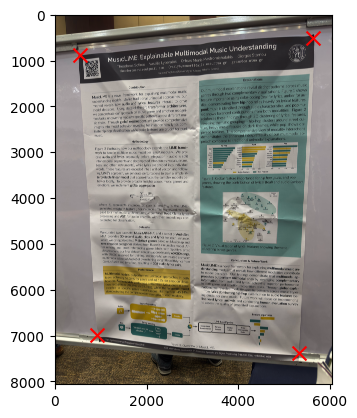

In [113]:
img = imgs[1]
res = image_doc_handler(img)
img_dat = cv2.imread(img)
src = np.array([list(p) for p in res[0]["bbox"].values()])
dst = np.array(
    [
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1],
    ]
)
shape = np.flip(img_dat.shape[:2])
src = src * shape
dst_scaled = find_dest_doc(src)
src_flipped_y = np.copy(src)
src_flipped_y[:, 1] = shape[1] - src[:, 1]
plt.imshow(cv2.cvtColor(img_dat, cv2.COLOR_BGR2RGB))
plt.scatter(src_flipped_y[:, 0], src_flipped_y[:, 1], marker="x", color="red", s=100)

In [114]:
dst_scaled

[[0, 0], [0, 8064], [5096, 0], [5096, 8064]]

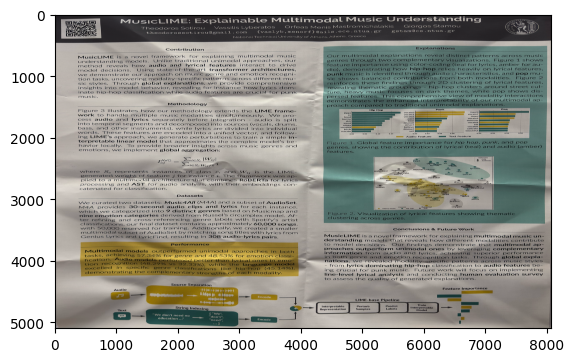

In [116]:
dst_mtx= np.array(dst_scaled).astype("float32")
src_mtx = np.array(src_flipped_y).astype("float32")
M = cv2.getPerspectiveTransform(src_mtx, np.flip(dst_mtx,axis=-1))
dst_size=tuple(np.flip(dst_mtx.max(axis=0)).astype('int').tolist())

warped = cv2.warpPerspective(img_dat, M, dst_size, flags=cv2.INTER_LINEAR)
# warped_flipped=cv2.
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

In [ ]:
def extract_poster_img(img: str):
    res = image_doc_handler(img)
    img_dat = cv2.imread(img)
    src = np.array([list(p) for p in res[0]["bbox"].values()])
    shape = np.flip(img_dat.shape[:2])
    src = src * shape
    dst_scaled = find_dest_doc(src)
    src_flipped_y = np.copy(src)
    src_flipped_y[:, 1] = shape[1] - src[:, 1]

    dst_mtx = np.array(dst_scaled).astype("float32")
    src_mtx = np.array(src_flipped_y).astype("float32")
    M = cv2.getPerspectiveTransform(src_mtx, np.flip(dst_mtx, axis=-1))
    dst_size = tuple(np.flip(dst_mtx.max(axis=0)).astype("int").tolist())

    warped = cv2.warpPerspective(img_dat, M, dst_size, flags=cv2.INTER_LINEAR)
    return warped


for img in tqdm(imgs):
    img_path = Path(img)
    warped = extract_poster_img(img)
    target_path = img_path.parent / "warped" / img_path.parts[-1]

    cv2.imwrite(str(target_path), warped)

 17%|█▋        | 5/29 [00:25<01:59,  5.00s/it]

In [122]:
target_path

PosixPath('figures/posters/IMG_2648.png/warped/IMG_2648.png')

In [15]:
def authors_text(texts):
    results = texts
    for textbox in results:
        commas = (
            textbox[0].count(",")
            + textbox[0].count("and")
            + textbox[0].count("&")
            + textbox[0].count(".")
        )

        textbox.append(commas)
    results.sort(key=lambda x: x[-1], reverse=True)
    return results[0][0] if len(results) else ""


def biggest_text(texts):
    results = texts
    for textbox in results:
        dims = textbox[2]
        poss = np.array([dims["tl"], dims["tr"], dims["br"], dims["bl"]]).astype(
            np.float32
        )
        area = cv2.contourArea(poss)
        textbox.append(area)
    results.sort(key=lambda x: x[-1], reverse=True)
    return results[0][0] if len(results) else ""

In [ ]:
outs = glob("figures/posters/warped/*.png")
for img in tqdm(outs):
    img_dat = cv2.imread(img)
    # downscale image
    dim_limit = 1080
    max_dim = max(img_dat.shape)
    if max_dim > dim_limit:
        resize_scale = dim_limit / max_dim
        img_dat = cv2.resize(img_dat, None, fx=resize_scale, fy=resize_scale)
    cv2.imwrite("figures/posters/reduced/" + img.split("/")[-1], img_dat)

100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


In [16]:
data = []
for img in tqdm(outs):

    texts = image_to_text(img, "eng")
    title = biggest_text(texts)
    authors = authors_text(texts)

    # print(title, authors)
    data.append({"title": title, "authors": authors, "texts": texts, "img": img})

100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


In [17]:
data

[{'title': 'Exploring the Distribution of Cell Subpopulations in',
  'authors': 'Yaqi Deng, Wenjie Cai, Bentao Song, Bin Yang. Lingming Kong. Qingfeng Wang* , Jun Huang»',
  'texts': [['Yaqi Deng, Wenjie Cai, Bentao Song, Bin Yang. Lingming Kong. Qingfeng Wang* , Jun Huang»',
    0.5,
    {'tl': (0.3226744334505008, 0.7132936505531791),
     'tr': (0.6642441825863205, 0.7132936505531791),
     'bl': (0.3226744334505008, 0.6996124034323672),
     'br': (0.6642441825863205, 0.6996124034323672)},
    0.004673115691009144,
    6],
   ['cancer with poor prognosis and high morbidity and mortality.',
    1.0,
    {'tl': (0.037790709064335626, 0.6395502646705741),
     'tr': (0.27761627567403613, 0.6395502646705741),
     'bl': (0.037790709064335626, 0.6259689925150546),
     'br': (0.27761627567403613, 0.6259689925150546)},
    0.0032571370289318224,
    3],
   ['Stain Density Estimation, CN: Color Normalization, IBLT: Inverse BE Transform.',
    1.0,
    {'tl': (0.3212209398993957, 0.2288359

In [ ]:
# curl 'https://ieeexplore.ieee.org/rest/search/pub/10887540/issue/10887541/toc' \
#   -H 'accept: application/json, text/plain, */*' \
#   -H 'accept-language: en-US,en;q=0.9' \
#   -H 'content-type: application/json' \
#   -b 'AMCVS_8E929CC25A1FB2B30A495C97%40AdobeOrg=1; s_cc=true; CloudFront-Key-Pair-Id=KBLQQ1K30MUFK; TS011ecef4=01c1c020ddd95d95c059f59b6e2b28b1e9ce792082896a1ec6edf5810d326b2ad2405e1233708f67d19d28fb2036f4c8188deb7b70; TS013304a6=01c1c020ddd95d95c059f59b6e2b28b1e9ce792082896a1ec6edf5810d326b2ad2405e1233708f67d19d28fb2036f4c8188deb7b70; tempuid=; TS01d04746=012f3506230b49406c3ac6f9a22025b987ef9f8fc439ef0bd33389728336b141f3119c5d847172f40a3dea1c8eb0d89dbaae97d1a5; TS01537e19=012f350623a4d266634e9d44e5d65784ed8833f7849ba68a4a4f9c8c2a61610d9f7557791de0b5a49f62049bffb6b0d51faded29f7; _uirefck=N; IBPJL=N#; IBPBC=M1; ieeeUserInfoCookie=%7B%22userInfoId%22%3A%22100944623%22%2C%22cartItemQty%22%3A0%2C%22name%22%3A%22BENDIKT%20KANTZ%22%2C%22authStatus%22%3A%22success%22%2C%22lastUpdated%22%3A7257328187281423665%2C%22env%22%3A%22pr%22%7D; TS01797c2d=012f350623f2191abb1cd5ac1f5f53fdffa5eae989857603191d29c3ee74481fc4a83691c711bbd9b394f7f0821148ac965f8e04c3; ieeeSSO=7N2b1Y5pKzXaCt9ZPaq6p8/bWYM+iCWoejY7ObM+3S6jnEDXtfL0nwBppt2cFBru; opentoken=T1RLAQLBVeibpVQCQ5rJ8K701vnFnFC6VRCtEM8ALoaS4MVV9FuFnau9AACAuFR7j4KgrEnM_jVJDeTtO5n3zeazXeQB3nnvanHh9AlY2H_kmStf0l0jAsIB9CrjW0P2gKAQyfcj0Y4p9Zta00s-3O07EVmprOJESoc2cvbGMVb9ZJBTpHZGa8r8GStNfkPJmgR3sgIy0B7KV0lkg53N95vJiZbd3WCI09-tE9s*; electPref=; PF=BbPelMV5AoMi4I5eLMgrc0exeRfYIIIsAfcHkHykIjrf; TS01f293bb=012f350623293b84906c5d88380289fc01789ca80d605e6f125a8a83c02e36dc4b70b7bd1233814372520a84a66a8aa3ea16d8bd2a17cfe1baf54de5461b893fb9b7fc2698; PA.Global_Websession=eyJ6aXAiOiJERUYiLCJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2Iiwia2lkIjoiLWcybHB3T0pZYWlVamFEZm9QSEtNejkyVHE4IiwicGkuc3JpIjoiU05XcFA2MmNQek1zQWpvYUNfNk9aejk1eHFNLlRrbyJ9..zWfZsiWr85rhaGdwIThyvw.tDdB6hJy9sba17ld0Jf6XviHmtTPnPaFjfeRgl3g9BqFWgHC6ric3HWw2lSQkacomKwmZqPKAYzgJWo2yo1z8DRL3aks_aBlkAeFqe9AQvJNB00XgfjITqziTVp_OZ_vmNdca1UY5p6vJlwjEb_TBxesh1Np2o4WnzPatu-rYX-L2o-_F2RkhuPFB-466H4BJd8lrB2pK3NXMIVUslYyTTPfau7y1faA2_aJX_w1TlGV6CWIcIcSDW2Cysbird59NkQ1PMvOf0XpoqtYvaToXchwpI_BUo25HJu_UDhhltR5YBC1s9cSh3at3pN0rKhMmyPF_N7ZliMsqVHuKBzPXgx13EoksZYxEAKt3IFePf8nwp_UPXnL6ACKzvAfRyAjHfTgULf7FTh1pFqzXHAyDKI9dsp1TuYU0zoXIzANRbFzKRrarTkM7gZWccUVdamcGoil0kltxBnicm1kv7Yc80U-RHai9UEVISHJZEJOw_DaF3JughqrzlRKyK8mttxLEGUjTreZ5fj1eUmWd7T289XJ_Fegmvqgiw7LHixelmdX9a3Lje5uxAV3KDbwdjoAqCx4KwxRQnJLBZKlXWwOzA.nRIFxj_EbQjUdEei9FKtgQ; TS01df59e9=012f350623ed53dd07fe4b65bfba85b9925a9fe6c18f85bb2d10b6aaa7d143a798d5cbf6f11e8ee241332877c725ee871cc75a6f68af9ba62a7f7a976e2df2ef974768ac92cc009485c985a677a10c3bffe213c551; ipCheck=103.174.81.162; AWSALBAPP-1=_remove_; AWSALBAPP-2=_remove_; AWSALBAPP-3=_remove_; ipList="129.27.168.138,129.27.169.114,129.27.173.218,129.27.232.246,129.27.225.140,129.27.239.168,129.27.226.228,129.27.169.67,103.174.81.162"; _zitok=e0401d100ec7fffbfb3c1744008132; WLSESSION=3942871562.47873.0000; TS016349ac=01f15fc87c40431cb478fd363b7be41858ae7b2252beecbbe0a51a9cee7b738a514cc45aa12acccdaaf933024e8966a09425249d82; JSESSIONID=257C33E9129AD1C14C5F363C48296D4B; TS0154b67f=012f35062330ed75db961d79b53282b7a1ab288b2d3678aa61c38ef4e3d379ab2ebbb8774374bcd7b5a2e4150862ba6a2e422cfadd; ERIGHTS=Kcx2BzM4suvTRIUP0S4wbwCc0yoJZMbE0c*2vBDAg1Zy9utOpNqRLdS6Qx3Dx3D-18x2dZWmoejx2F5yVOTvPiGqrnax2BQx3Dx3DvjazUYy1B3jA2nKP1YQfbwx3Dx3D-eI3qZRBPEpptHrsBwmDJWwx3Dx3D-PHtmiFx2BHcxxRmFWzvhDaEhQx3Dx3D; CloudFront-Policy=eyJTdGF0ZW1lbnQiOiBbeyJSZXNvdXJjZSI6Imh0dHBzOi8vaWVlZXhwbG9yZS5pZWVlLm9yZy9tZWRpYXN0b3JlL0lFRUUvY29udGVudC9tZWRpYS8xMDg4NzU0MC8xMDg4NzU0MS8xMDg5MDI1Ny8qIiwiQ29uZGl0aW9uIjp7IkRhdGVMZXNzVGhhbiI6eyJBV1M6RXBvY2hUaW1lIjoxNzQ0MTE3MTUxfSwiSXBBZGRyZXNzIjp7IkFXUzpTb3VyY2VJcCI6IjEwMy4xNzQuODEuMTYyIn19fV19; CloudFront-Signature=lcr6dMMjEFjNjYVt1hYEtvk1a~mNbOHjWxlClqj36ZgMt0xBE0h1nxaUJ9gm3RXTf92VrODuG9~-ODiMpiU7cWw-HiSNQkD8XnSyoklMZIkQJCFVeLVIidWn5MWQp9GzmioDwZgS~NaSMsg5xtyhma4gHxKQF9wzwQIHdPGncm3pgKHyzULL4YahpcjZllcvO6AVhOBw~M4qrNB5YKQ4mNzWcsu6HPVSRil9S9~OREgRCgdR3I-G7pKzNSyfmqOiB2ecibF5eLqbYNJPVG1b6V9RPkDYHBg9nK0lB0jEkcYpktMYmpmimqRyOBUdvpWIR9eYfrpHhDLlLVrw-QHP3A__; seqId=11974348; AWSALBAPP-0=AAAAAAAAAACFA1Njp2GCyKpcLLlHDqE+4RoRouNkwWNByMu9iOXTYzdHH4qs5tD7fwe8WCg2dNtTFXRhbn99I+fkYPb8KBE8n6dH8k2nz/+9rjoAy2Q7bfR4nSygyqyUF1tzG/vGK28EW/IvrCRuA+NUam2QEYLzEZ0NXawo3EdgkWLVqh7s7oeBXcavUAfAePGC6MvYEX+p08WWwe5Nfw==; TSaf720a17029=0807dc117eab2800009d91d05842f407c8fecfec8d2bc0368d8968d300d367f44b9ab4f8985be753c5f1d8aa6b36a149; TS8b476361027=0807dc117eab200006b04f3e6f465571a389225524d00cce2af862144727c44ee5adc4d92d4cc5aa08953cfa9c113000f7ba0ed06bbc010fb589e9b03e161b55fc6e0e4e9e297f8139582c0952740adc186ab68b4b1d7a3597d7a0afdb26f2df; s_sq=ieeexplore.prod%3D%2526c.%2526a.%2526activitymap.%2526page%253DXplore%252520Conference%252520ToC%2526link%253DFilter%2526region%253DpublicationIssueMainContent%252520global-margin-px%2526pageIDType%253D1%2526.activitymap%2526.a%2526.c%2526pid%253DXplore%252520Conference%252520ToC%2526pidt%253D1%2526oid%253DFilter%2526oidt%253D3%2526ot%253DSUBMIT; AMCV_8E929CC25A1FB2B30A495C97%40AdobeOrg=359503849%7CMCIDTS%7C20186%7CMCMID%7C13789644795833757590544312258178759318%7CMCAID%7CNONE%7CMCOPTOUT-1744122579s%7CNONE%7CvVersion%7C5.0.1; utag_main=v_id:01960efc28ba000b39c83781d2960507500a006d00819$_sn:3$_se:21$_ss:0$_st:1744117189731$vapi_domain:ieeexplore.ieee.org$ses_id:1744115173346%3Bexp-session$_pn:11%3Bexp-session' \
#   -H 'dnt: 1' \
#   -H 'origin: https://ieeexplore.ieee.org' \
#   -H 'priority: u=1, i' \
#   -H 'referer: https://ieeexplore.ieee.org/xpl/conhome/10887540/proceeding?isnumber=10887541&sortType=vol-only-seq&searchWithin=uncertainty' \
#   -H 'sec-ch-ua: "Chromium";v="134", "Not:A-Brand";v="24", "Brave";v="134"' \
#   -H 'sec-ch-ua-mobile: ?0' \
#   -H 'sec-ch-ua-platform: "macOS"' \
#   -H 'sec-fetch-dest: empty' \
#   -H 'sec-fetch-mode: cors' \
#   -H 'sec-fetch-site: same-origin' \
#   -H 'sec-gpc: 1' \
#   -H 'user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36' \
#   -H 'x-security-request: required' \
#   --data-raw '{"isnumber":"10887541","sortType":"vol-only-seq","searchWithin":["uncertainty"],"punumber":"10887540"}'

In [18]:
pub = 10887540
issue = 10887541
results=req.post(
    f"https://ieeexplore.ieee.org/rest/search/pub/{pub}/issue/{issue}/toc",
    json={
        "isnumber": issue,
        "sortType": "vol-only-seq",
        "searchWithin": ["uncertainty"],
        "punumber": pub,
    },
)
results.json()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [19]:
results.text

"<html><head><title>Request Rejected</title></head><body>The requested URL was rejected. Please consult with your administrator.<br><br>Your support ID is: < 8203162014024770768><br><br><a href='javascript:history.back();'>[Go Back]</body></html>"

In [213]:
import arxiv

client = arxiv.Client()
arxiv_data = []
for poster in tqdm(data):
    # poster = data[0]
    query = f"{poster['title'].lower()} {poster['authors'].lower().split(',')[0]}"
    search = arxiv.Search(
        query=query, max_results=1, sort_by=arxiv.SortCriterion.Relevance
    )
    results = list(client.results(search))
    if len(results) > 0:
        result = results[0]
        poster["arxiv"] = result
        poster["title_a"] = result.title
        poster["authors_a"] = ",".join([a.name for a in result.authors])
        poster["abstract_a"] = result.summary
        poster["url"] = result.links[0].href
    else:
        poster["title_a"] = poster["title"]
        poster["authors_a"] = ",".join([str(poster["authors"])])
        poster["abstract_a"] = ""
        poster["url"] = ""

    arxiv_data.append(poster)

100%|██████████| 52/52 [04:01<00:00,  4.65s/it]


In [214]:
from pylatex.utils import escape_latex

In [216]:
with open("./posters.tex", "w") as f:
    f.write("\\begin{longtblr}{|m{70mm}|X|}  \n")
    f.write("\\hline \n")
    f.write("Poster & Information  \\\\  \n")
    f.write("\\hline \n")
    for poster in arxiv_data:
        f.write(
            "\\raisebox{-\\height}{\\includegraphics[width=68mm]{"
            + "out_reduced/"
            + poster["img"].split("/")[-1]
            + "}} & \\textbf{"
            + escape_latex(poster["title_a"].replace("≥", " "))
            + "} \n \\textit{"
            + escape_latex(poster["authors_a"].replace("≥", " "))
            + "} \n\n"
            + escape_latex(poster["title"].replace("≥", " "))+ "\n\n"
            + "\\url{"+escape_latex(poster["url"])+"}"
            + "\\\\"
        )

    f.write("\\end{longtblr}")